In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import skew, kurtosis, boxcox, gaussian_kde
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.impute import KNNImputer
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.utils import class_weight
from sklearn.base import clone
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import HyperbandPruner

pd.set_option('display.max_columns', None)  # Set to None to display all columns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


----------------------
# EDA #
----------------------

In [3]:
# Import Data: 
train  = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test  = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

### _Raw Data_ ###

In [4]:
# First look at the data:
display(train)
display(train.describe())

# Let's see if any columns are non-numeric:
print("\n\nNon-Numeric Columns:")
display(train.describe(include=['O']))

# And any missingness in our data
print("Missing Values in Columns with Missingness:\n") 
missing_cols = train.isna().sum()[train.isna().sum() > 0].index.to_list()
for feature in missing_cols:
    print(
        (feature) + "\t",
        (str(train[feature].isna().sum())) + "\t",
        (f"{train[feature].isna().sum() / len(train):.1%}") + "\t",
    )

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,A,51.618996,78.526968,65.821872,29.708112,0.296850,17167.209610,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,27.1887,285.628059,344.644105,505.006814,257.432377,61.910576,0.772304,85.233928,6.682597,0.038208,1.050225,0.761025,39.852923,2.146113,33.648

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,615.000000,614.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,21.419492,231.322223,98.328737,1218.133238,550.632525,77.104151,0.688801,90.251735,11.241064,0.030615,1.403761,0.742262,36.917590,1.383792,27.165653,51.128326,401.901299,0.633884,0.367002,146.972099,94.795377,26.370568,1.802900,1.924830,26.388989,9.072700,3.064778,1731.248215,0.305107,69.582596,105.060712,69.117005,71.341526,6.930086,10306.810737,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,3.478278,183.992505,96.479371,7575.293707,2076.371275,159.049302,0.263994,51.585130,13.571133,0.014808,1.922210,0.281195,17.266347,0.538717,14.645993,21.210888,317.745623,1.912384,0.112989,86.084419,28.243187,8.038825,9.034721,1.484555,18.116679,6.200281,2.058344,1790.227476,1.847499,38.555707,68.445620,390.187057,165.551545,64.754262,11331.294051,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,19.420500,156.847239,27.834425,424.990642,257.432377,23.317567,0.563688,64.724192,5.066306,0.023482,1.050225,0.589575,29.782467,1.070298,7.030640,37.942520,188.815690,0.238680,0.295164,102.703553,78.232240,20.888264,0.005518,1.743070,14.715792,5.965392,1.648679,1111.160625,0.003042,30.927468,78.526968,4.324656,25.815384,0.296850,5164.666260,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,21.186000,193.908816,61.642115,627.417402,257.432377,42.554330,0.658715,79.819104,9.123000,0.027860,1.050225,0.730800,34.835130,1.351665,36.019104,49.180940,307.509595,0.238680,0.358023,130.050630,96.264960,25.248800,0.251741,1.743070,21.642456,8.149404,2.616119,1493.817413,0.085176,71.949306,78.526968,22.641144,36.394008,1.870155,7345.143424,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,23.657700,247.803462,134.009015,975.649259,257.432377,77.310097,0.772206,99.813520,13.565901,0.034427,1.228445,0.859350,40.529401,1.660617,37.935832,61.408760,507.896200,0.238680,0.426348,165.836955,110.640680,30.544224,1.058690,1.743070,34.058344,10.503048,3.910070,1905.701475,0.237276,109.125159,112.766654,49.085352,56.714448,4.88021



Non-Numeric Columns:


,Id,EJ
count,617,617
unique,617,2
top,000ff2bfdfe9,B
freq,1,395


Missing Values in Columns with Missingness:

BQ	 60	 9.7%	
CB	 2	 0.3%	
CC	 3	 0.5%	
DU	 1	 0.2%	
EL	 60	 9.7%	
FC	 1	 0.2%	
FL	 1	 0.2%	
FS	 2	 0.3%	
GL	 1	 0.2%	


---------------------------------------
#### Initial Observations ####
* Parameters will need to be scaled 
* Columns Id and EJ are non-numeric. Everything else is numeric. 
* There is not a significant amount of missingness, but 9 columns will need to have values imputed-- Two of which have ~10% missingness
* Outliers are a major problem in this dataset. So I will deal with that. 
---------------------------------------

### _Data Visualization_ ###

In [5]:
def plot_target_pie(train):
    fig = px.pie(
        train.assign(ClassMap=train.Class.map({0: "Class 0", 1: "Class 1"})),
        names="ClassMap",
        height=540,
        width=840,
        hole=0.65,
        title="Evaluating Class Imbalance",
        color_discrete_sequence=['#fa8c2f', '#4ed8ff'],
    )
    fig.update_layout(
        title_font_size=24,
        plot_bgcolor='white',
        paper_bgcolor='white',
        showlegend=False,
    )
    fig.add_annotation(
        x=0.5,
        y=0.5,
        align="center",
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=22,
        text="Target Overview:<br><b>Class",
    )
    fig.update_traces(
        hovertemplate=None,
        textposition="outside",
        texttemplate="%{label}<br>%{value} - %{percent}",
        textfont_size=16,
        rotation=62,
        marker_line_width=25,
        marker_line_color='white',
    )
    fig.show()

plot_target_pie(train)

**Conclusion:* Clearly some class imbalance-- Let's look at this as a function of each variable

In [6]:
def get_kde_estimation(data_series):
    kde = gaussian_kde(data_series.dropna())
    kde_range = np.linspace(
        data_series.min() - data_series.max() * 0.1,
        data_series.max() + data_series.max() * 0.1,
        len(data_series),
    )
    estimated_values = kde.evaluate(kde_range)
    estimated_values_cum = np.cumsum(estimated_values)
    estimated_values_cum /= estimated_values_cum.max()
    return kde_range, estimated_values, estimated_values_cum

def create_density_plots(data, target_col):
    
    numeric_cols = data.drop(target_col, axis=1).columns.tolist()
    n_cols = 5
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    axes = [(r, c) for r in range(1, n_rows + 1) for c in range(1, n_cols + 1)]

    fig1 = make_subplots(
        rows=n_rows,
        cols=n_cols,
        y_title="Probability Density",
        horizontal_spacing=0.06,
        vertical_spacing=0.04,
    )

    show_legend = True

    for k, ((current_row, current_col), feature) in enumerate(zip(axes, numeric_cols)):
        if k > 0:
            show_legend = False

        for target, color in zip((0, 1), ('#fa8c2f', '#00cdff')):
            kde_range, estimated_values, estimated_values_cum = get_kde_estimation(
                data.query(f"Class == {target}")[feature]
            )

            fig1.add_scatter(
                x=kde_range,
                y=estimated_values,
                line=dict(dash="solid", color=color, width=1),
                fill="tozeroy",
                name=f"Class {target}",
                legendgroup=f"Class {target}",
                showlegend=show_legend,
                row=current_row,
                col=current_col,
            )

            fig1.update_yaxes(
                tickfont_size=7,
                row=current_row,
                col=current_col,
            )

            fig1.update_xaxes(
                title_text=feature,
                titlefont_size=9,
                tickfont_size=7,
                row=current_row,
                col=current_col,
            )

    title = "Kernel Density Estimation for Numerical Features"

    fig1.update_annotations(font_size=14)
    fig1.update_layout(
        title=title,
        title_font_size=18,
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=1000,
        height=1340,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            xanchor="right",
            y=1.01,
            x=1,
        ),
    )

    fig1.show()

numeric_features = train.select_dtypes(include=['number']).columns.tolist()
create_density_plots(train[numeric_features], 'Class')


**Conclusion:** Lots of skewness. Lots of kurtosis. Some semi-normality? Will definitely require some transformations later on. 

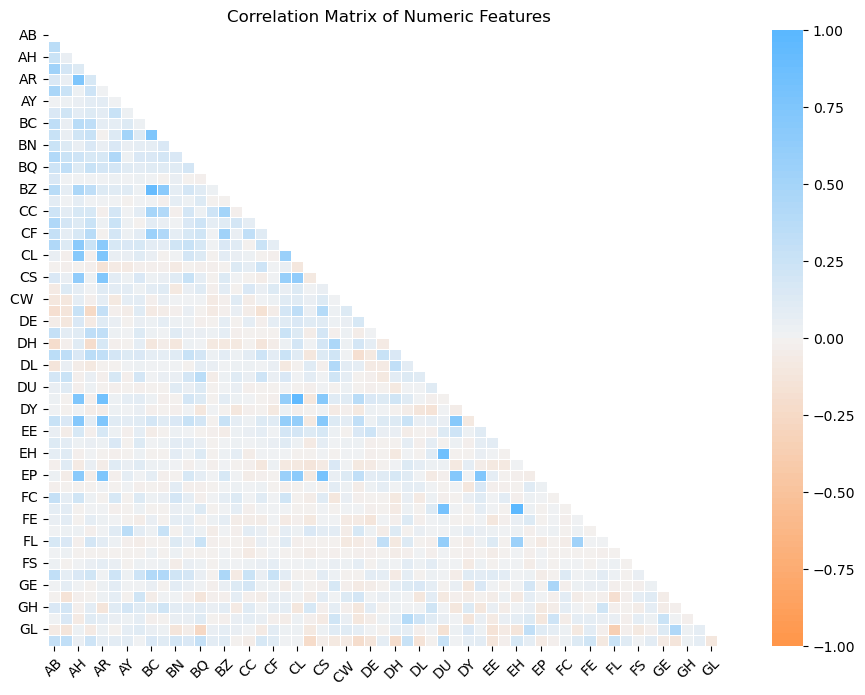

In [7]:
def plot_correlation_matrix(data):
    # Compute the correlation matrix
    correlation_matrix = data.corr()

    # Generate a mask for the upper triangle (to avoid duplicate and mirrored plots)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 8))

    # Create a custom color map
    cmap = sns.diverging_palette(33.6, 242, s=100, l=72, n=100)

    # Draw the heatmap using seaborn
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=False, fmt=".2f", linewidths=0.5, ax=ax, vmin=-1, vmax=1)

    # Customize the plot
    ax.set_title("Correlation Matrix of Numeric Features")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show the plot
    plt.show()
    
    return correlation_matrix

# Run the function on the numeric feature:
cor_mat = plot_correlation_matrix(train[numeric_features])

**Conclusion:** Features appear to largely be independent of one another, with few negative correlations.

Let's look at some of these individual correlations more closely

In [8]:
def get_correlation_pairs(dataframe):    # Calculate the absolute correlations
    correlations = dataframe.corr().abs()
    # Exclude the diagonal and lower triangle to avoid duplicates
    upper_tri = correlations.where(
        np.triu(np.ones(correlations.shape, dtype=bool), k=1)
    )
    # Flatten the upper triangle correlation matrix
    flattened_corr = upper_tri.stack().reset_index()
    flattened_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
    # Sort by absolute correlation in descending order
    sorted_corr = flattened_corr.sort_values('Correlation', ascending=False)
    # Convert to a list of tuples
    correlation_pairs = sorted_corr[['Feature 1', 'Feature 2']].apply(tuple, axis=1).tolist()
    return correlation_pairs

def plot_scatterplots(data, pairs, n):
    top_pairs = pairs[:n]  # Get the top n pairs

    n_cols = 4
    n_rows = int(np.ceil(n / n_cols))

    current_col = range(1, n_cols + 1)
    current_row = range(1, n_rows + 1)
    axes = [(r, c) for r in current_row for c in current_col]

    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        horizontal_spacing=0.1,
        vertical_spacing=0.06,
    )

    for k, ((current_row, current_col), (feature1, feature2)) in enumerate(
        zip(axes, pairs)):
        showlegend = (current_row == 1 and current_col == 1)  # Show legend only for the first subplot
        fig.add_scatter(
            x=data.query("Class == 0")[feature1],
            y=data.query("Class == 0")[feature2],
            mode="markers",
            name="Class 0",
            marker=dict(color="#4acded", size=3, symbol="diamond", opacity=0.5),
            legendgroup="Class 0",
            showlegend=showlegend,
            row=current_row,
            col=current_col,
        )
        fig.add_scatter(
            x=data.query("Class == 1")[feature1],
            y=data.query("Class == 1")[feature2],
            mode="markers",
            name="Class 1",
            marker=dict(color="#fa8c2f", size=2, symbol="circle", opacity=0.8),
            legendgroup="Class 1",
            showlegend=showlegend,
            row=current_row,
            col=current_col,
        )
        fig.update_xaxes(
            type="log",
            title_text=feature1,
            titlefont_size=10,
            tickfont_size=7,
            #gridcolor="#eaeaea",  # Set grid line color to light grey
            row=current_row,
            col=current_col,
        )
        fig.update_yaxes(
            type="log",
            title_text=feature2,
            titlefont_size=10,
            tickfont_size=7,
            #gridcolor="#eaeaea",  # Set grid line color to light grey
            row=current_row,
            col=current_col,
        )
        fig.update_xaxes(showline=True, linewidth=0.5, linecolor='lightgray', row=current_row, col=current_col)
        fig.update_yaxes(showline=True, linewidth=0.5, linecolor='lightgray', row=current_row, col=current_col)

    fig.update_annotations(font_size=14)
    fig.update_layout(
        title="Plotting the most closely related pairs (log scale)",
        title_font_size=18,
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=1000,
        height=1140,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            xanchor="right",
            y=1.01,
            x=1,
            itemsizing="constant",
        ),
    )

    fig.show()

# Example usage:
pairs = get_correlation_pairs(train[numeric_features].drop('Class', axis=1))
plot_scatterplots(train, pairs, 30)


Now, let's see if there's any structure to these relationships:

<Figure size 640x480 with 0 Axes>

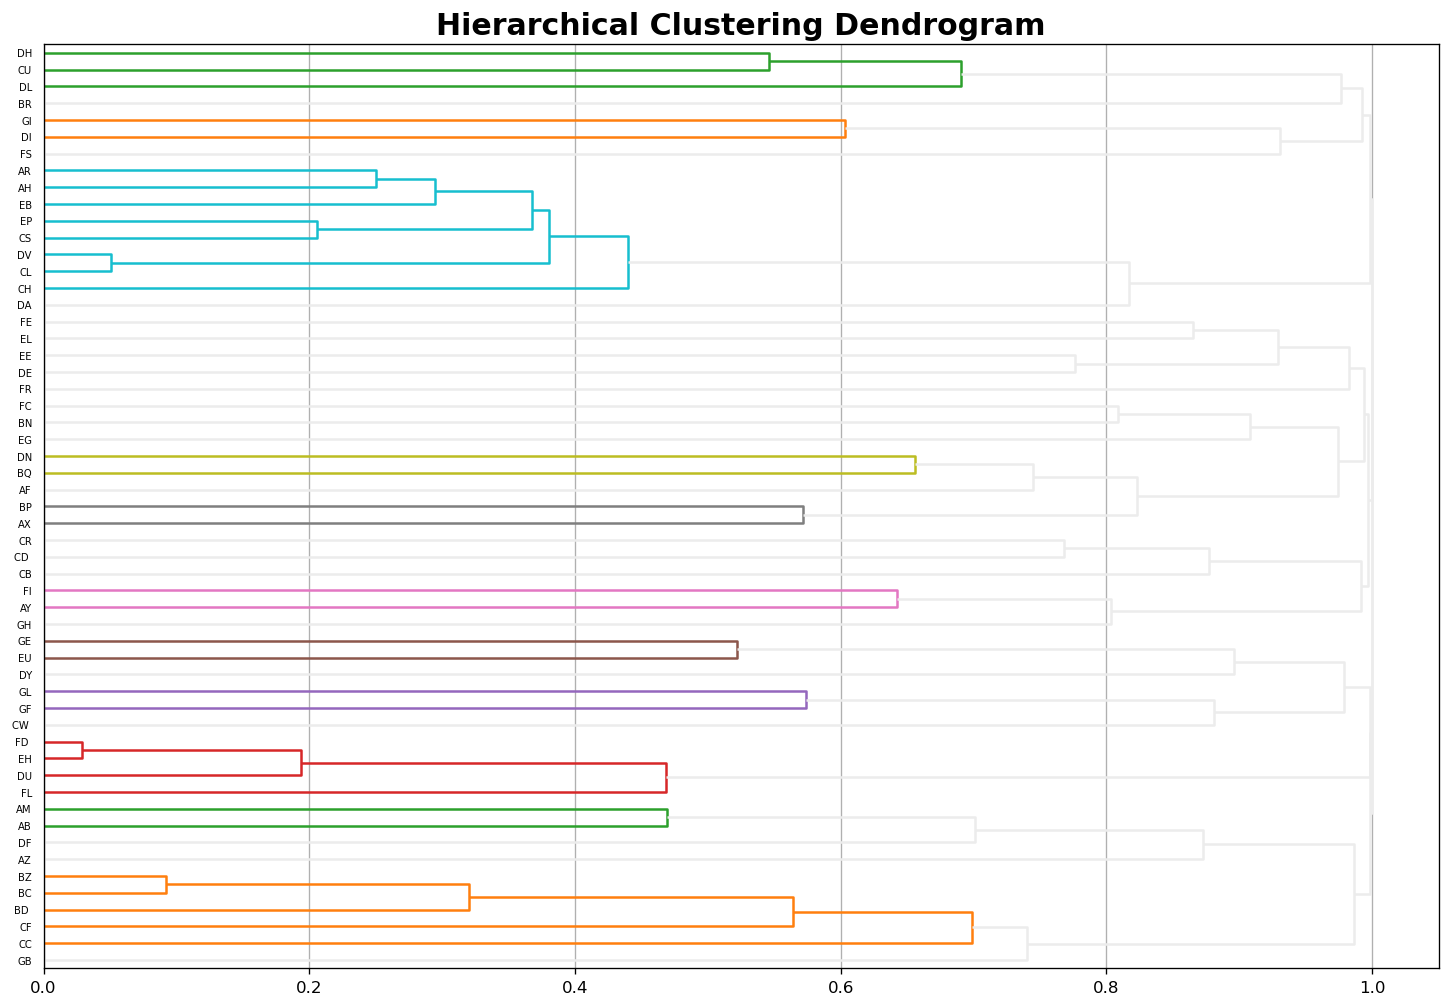

In [9]:
def hierarchical_clustering(data, figsize=(15, 10), dpi=120, above_threshold_color='#ececec', orientation='right'):
    plt.clf()  # Clear existing plot
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    correlations = data.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = hierarchy.linkage(squareform(converted_corr), 'complete')

    dn = hierarchy.dendrogram(Z, labels=data.columns.tolist(), ax=ax,
                              above_threshold_color=above_threshold_color, orientation=orientation)
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title('Hierarchical Clustering Dendrogram', fontsize=18, fontweight='bold')
    plt.show()

    # Retrieve the pairs of columns based on the dendrogram
    labels = dn['ivl']  # Get the reordered labels from the dendrogram
    leaves = dn['leaves']  # Get the leaf node order
    pairs = [(labels[i], labels[j]) for i, j in zip(leaves[:-1], leaves[1:])]

    # Sort the pairs based on their correlation
    pairs = sorted(pairs, key=lambda pair: -converted_corr.loc[pair[0], pair[1]])

    return pairs

# Applying it to our data:
numeric_features = train.select_dtypes(include=['number']).columns.tolist()
pairs = hierarchical_clustering(train[numeric_features].drop('Class', axis=1))

**Conclusions:** Some clear clusters emerging-- Particularly the ones in blue and orange. We'll come back to this later. 

----------------------
# Prepare Our Data #
----------------------

In [10]:
# Re-import Data: 
train  = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test  = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [11]:
# Re-determine the numeric features (excluding the ID and Class columns)
numeric_features = train.select_dtypes(include='number').columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Id', 'Class']]

In [12]:
# Make EJ numeric:
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].map({'A': 0, 'B': 1})

In [13]:
# For future reference:
skewness_before = train[numeric_features].skew()
kurtosis_before = train[numeric_features].kurtosis()

skew_kurt_before = pd.concat([skewness_before, kurtosis_before], axis=1)
skew_kurt_before.columns = ['Skewness', 'Kurtosis']

In [14]:
# Those plots showed that there are some pretty significant outliers, so let's remove the most extreme ones: 

def remove_outliers(train, test, numeric_features, threshold=4):
    # Combine train and test data
    combined_data = pd.concat([train, test])

    # Iterate over each numeric column and replace outliers > threshold SD
    for column in numeric_features:
        z_scores = (combined_data[column] - combined_data[column].mean()) / combined_data[column].std()
        combined_data.loc[abs(z_scores) >= threshold, column] = combined_data[column].quantile(1 - (1 / len(combined_data[column])))

    # Reset the index of the combined  DataFrame
    combined_data.reset_index(drop=True, inplace=True)

    # Split the combined data back into train and test
    train_no_outliers = combined_data[:len(train)]
    test_no_outliers = combined_data[len(train):]

    return train_no_outliers, test_no_outliers

# Run the function on the numeric feature:
train_no_outliers, test_no_outliers = remove_outliers(train, test, numeric_features)

In [15]:
# Apply transformations to numeric features in the train and test datasets based on skewness and kurtosis.

def apply_transformations(train, test, numeric_features):
    
    # Combine train and test data
    combined_data = pd.concat([train, test]).reset_index(drop=True)

    transformed_columns = []
    nontransformed_columns = []
    cols_to_remove = []
    
    skewness = combined_data[numeric_features].skew()
    kurtosis = combined_data[numeric_features].kurtosis()

    for column in combined_data[numeric_features].columns:
        
        # Apply Box-Cox transformation if highly skewed and leptokurtic
        if skewness[column] > 1 and kurtosis[column] > 3:
            transformed_column, _ = boxcox(combined_data[column] + 1)
            combined_data[column + '_transformed'] = transformed_column.copy()
            transformed_columns.append(column + '_transformed')
            cols_to_remove.append(column)
        
        # Apply log transformation if highly skewed
        elif skewness[column] > 1:
            transformed_column = np.log1p(combined_data[column])
            combined_data[column + '_transformed'] = transformed_column.copy()
            transformed_columns.append(column + '_transformed')
            cols_to_remove.append(column)
        
        # Otherwise, no transformation required
        else:
            transformed_column = combined_data[column]
            nontransformed_columns.append(column)

    # Split the combined data back into train and test
    train_transformed = combined_data[:len(train)].copy()
    test_transformed = combined_data[len(train):].copy()

    # Remove the transformed columns from train and test
    train_transformed.drop(cols_to_remove, axis=1, inplace=True)
    test_transformed.drop(cols_to_remove, axis=1, inplace=True)

    return train_transformed, test_transformed

# Now let's apply it:
train_transformed, test_transformed = apply_transformations(train_no_outliers, test_no_outliers, numeric_features)

In [16]:
# Re-Re-determine the numeric features (excluding the ID and Class columns)
numeric_features = train_transformed.select_dtypes(include='number').columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Id', 'Class']]

In [17]:
# See how much this helped:
skewness = train_transformed[numeric_features].skew()
kurtosis = train_transformed[numeric_features].kurtosis()

skew_kurt = pd.concat([skewness, kurtosis], axis=1)
skew_kurt.columns = ['Skewness', 'Kurtosis']

print("Before:")
display(skew_kurt_before.T)

print("\nAfter:")
display(skew_kurt.T)

Before:


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Skewness,5.927245,3.751057,10.094184,6.434969,13.259275,4.400920,24.270320,0.799989,19.726787,10.455121,-0.452831,6.464570,1.380746,21.804495,22.193979,8.775588,5.568676,4.087235,9.302033,6.274781,11.398838,2.448436,7.944825,0.961026,-0.406131,1.644509,2.039423,13.798896,0.772547,4.401212,1.246755,0.915665,14.590580,13.167744,1.970481,8.677239,2.059802,9.608652,20.084787,-0.147017,9.282442,14.985507,11.366151,23.402877,5.300799,1.388188,6.601233,24.618316,21.801439,3.145217,4.913469,3.042299,0.889175,1.193504,0.499068
Kurtosis,53.027994,30.046579,123.880298,48.583199,202.672415,45.729751,597.760144,3.506581,420.083106,147.053424,0.599158,56.809986,0.956898,501.991749,528.384361,97.155206,60.366912,29.352222,123.494289,66.545104,149.219874,16.973772,97.857306,3.988453,-1.387606,8.481997,5.340953,244.448832,2.936944,31.507376,9.816433,1.948110,237.661082,194.716344,6.742422,109.335685,8.224655,124.601587,448.879479,-1.720804,118.387190,241.049591,176.828544,566.340902,42.088794,10.408678,56.188731,609.504648,516.391805,28.560569,31.149482,12.625349,2.247816,1.150780,-1.712329



After:


,AZ,BN,CU,CW,DH,DL,DN,EJ,EL,FI,GH,GL,AB_transformed,AF_transformed,AH_transformed,AM_transformed,AR_transformed,AX_transformed,AY_transformed,BC_transformed,BD _transformed,BP_transformed,BQ_transformed,BR_transformed,BZ_transformed,CB_transformed,CC_transformed,CD _transformed,CF_transformed,CH_transformed,CL_transformed,CR_transformed,CS_transformed,DA_transformed,DE_transformed,DF_transformed,DI_transformed,DU_transformed,DV_transformed,DY_transformed,EB_transformed,EE_transformed,EG_transformed,EH_transformed,EP_transformed,EU_transformed,FC_transformed,FD _transformed,FE_transformed,FL_transformed,FR_transformed,FS_transformed,GB_transformed,GE_transformed,GF_transformed,GI_transformed
Skewness,0.535031,-0.452831,0.643915,-0.406131,0.582624,0.749383,0.902632,-0.585638,-0.147017,0.476035,0.882636,0.499068,0.295818,0.512274,4.256804,0.636181,4.420523,0.594339,1.390233,0.598210,3.915674,2.600639,-0.309564,0.908445,2.151078,9.999869,14.228393,1.264183,0.151018,0.376507,3.209518,0.287267,2.607992,0.647811,0.571704,1.509429,1.749904,17.507002,6.752508,0.206481,1.547541,0.123353,2.036907,0.540916,3.987394,0.177992,10.008176,0.180155,1.692082,8.624103,0.237879,15.041358,-0.115788,2.151667,0.177894,-0.497716
Kurtosis,1.540032,0.599158,1.660583,-1.387606,1.579246,5.112104,1.870564,-1.662428,-1.720804,2.055242,2.203744,-1.712329,-0.444594,3.159899,25.447221,0.442835,26.755995,2.508819,0.288609,-1.272468,34.946298,11.571131,-0.469800,8.227568,3.706309,98.317100,201.173389,5.095219,1.731880,2.197048,11.965428,4.848303,21.162317,3.251303,0.241787,0.437458,6.570747,305.486955,50.431685,0.947742,6.663965,0.081445,12.181640,-1.046831,25.137353,-0.760867,98.483487,-1.358258,4.501773,72.610898,-0.027655,238.568846,-0.041441,5.157450,0.045376,0.228798


Yeah, that's a massive difference. Nice. 

Now let's impute the missing data. 

In [18]:
def perform_knn_imputation(train, test, numeric_features, n_neighbors=10):

    # Combine train and test data
    combined_data = pd.concat([train, test]).reset_index(drop=True)

    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform imputation on combined data
    imputed_data = pd.DataFrame(imputer.fit_transform(combined_data[numeric_features]), columns=numeric_features)

    # Split the imputed data back into train and test
    train_imputed = imputed_data[:len(train)].copy()
    test_imputed = imputed_data[len(train):].copy()

    return train_imputed, test_imputed

# Usage example

train_imputed, test_imputed = perform_knn_imputation(train_transformed, test_transformed, numeric_features)

In [19]:
# Make sure it worked: 
print("Missing Values in Training Columns with Missingness: \n", 
      train_imputed.isnull().sum()[train_imputed.isnull().sum() > 0])

print("Missing Values in Testing Columns with Missingness: \n", 
      test_imputed.isnull().sum()[test_imputed.isnull().sum() > 0])

Missing Values in Training Columns with Missingness: 
 Series([], dtype: int64)
Missing Values in Testing Columns with Missingness: 
 Series([], dtype: int64)


Great! Now let's scale each of our continuous columns. 

In [20]:
def scale_data(train, test, numeric_features):
    """
    Scale the numeric features in the train and test datasets using StandardScaler.

    Args:
        train (pd.DataFrame): Training dataset.
        test (pd.DataFrame): Test dataset.
        numeric_features (list): List of numeric features to scale.

    Returns:
        pd.DataFrame: Scaled train dataset.
        pd.DataFrame: Scaled test dataset.
    """
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training data
    scaler.fit(train[numeric_features])

    # Transform the training and test data
    train_scaled = scaler.transform(train[numeric_features])
    test_scaled = scaler.transform(test[numeric_features])

    # Create DataFrame with scaled data
    train_scaled = pd.DataFrame(train_scaled, columns=numeric_features, index=train.index)
    test_scaled = pd.DataFrame(test_scaled, columns=numeric_features, index=test.index)

    # Combine the scaled numeric features with the non-numeric features
    train_scaled = pd.concat([train_scaled, train.drop(numeric_features, axis=1)], axis=1)
    test_scaled = pd.concat([test_scaled, test.drop(numeric_features, axis=1)], axis=1)

    return train_scaled, test_scaled

# Let's apply it:
train_scaled, test_scaled = scale_data(train_imputed, test_imputed, numeric_features)

In [56]:
# Add 'EJ' column back to the train and test datasets
train_scaled['EJ'] = train['EJ']
test_scaled['EJ'] = test['EJ']

Missing Values in Testing Columns with Missingness: 
 Series([], dtype: int64)


In [55]:
# Get the final test and training sets:
X_train = train_scaled
X_test = test_scaled

Y_train = train['Class'].values

In [40]:
# Define the hyperparameters for CatBoost
catboost_params = {
    'n_estimators': 20,
    'max_depth': 3,
    'l2_leaf_reg': 0.5,
    'early_stopping_rounds': 5,
    'verbose': 0,
}

# Define the hyperparameters for XGBoost
xgboost_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': np.sum(Y_train == 0) / np.sum(Y_train == 1)  # Adjust class weights
}

# Define the hyperparameters for LightGBM
lightgbm_params = {
    'n_estimators': 20,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'class_weight': 'balanced'  # Adjust class weights
}

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=42)

# Calculate class weights for CatBoost manually
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update CatBoost parameters with class weights
catboost_params['class_weights'] = class_weight_dict

# Create the classifiers
catboost_classifier = CatBoostClassifier(**catboost_params)
xgboost_classifier = xgb.XGBClassifier(**xgboost_params)
lightgbm_classifier = lgb.LGBMClassifier(**lightgbm_params)

# Create the voting ensemble
ensemble_classifier = VotingClassifier(
    estimators=[
        ('catboost', catboost_classifier),
       ('xgboost', xgboost_classifier),
        ('lightgbm', lightgbm_classifier)
    ],
    voting='soft'  # Use soft voting
)

# Feature selection using univariate selection (SelectKBest)
k = 50  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
x_train_selected = selector.fit_transform(x_train, y_train)
x_val_selected = selector.transform(x_val)

# Feature selection using recursive feature elimination (RFE)
rfe = RFE(estimator=ensemble_classifier, n_features_to_select=k)
x_train_selected = rfe.fit_transform(x_train_selected, y_train)
x_val_selected = rfe.transform(x_val_selected)

# Train the ensemble classifier on the selected features
ensemble_classifier.fit(x_train_selected, y_train)

# Make predictions on the training set and calculate metrics
train_predictions = ensemble_classifier.predict(x_train_selected)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

print("Metrics on the training set:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1-score: {train_f1}")
print()

# Make predictions on the validation set and calculate metrics
val_predictions = ensemble_classifier.predict(x_val_selected)
val_accuracy = accuracy_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)

print("Metrics on the validation set:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1-score: {val_f1}")
print()

# Check if the ensemble is overfitting
if train_accuracy > val_accuracy:
    print("Warning: The ensemble may be overfitting the data.\n")

# Make predictions on the training set probabilities
train_probabilities = ensemble_classifier.predict_proba(x_train_selected)[:, 1]
train_loss = log_loss(y_train, train_probabilities)

print("Binary cross-entropy loss on the training set:", train_loss)

# Make predictions on the validation set probabilities
val_probabilities = ensemble_classifier.predict_proba(x_val_selected)[:, 1]
val_loss = log_loss(y_val, val_probabilities)

print("Binary cross-entropy loss on the validation set:", val_loss)

Metrics on the training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Metrics on the validation set:
Accuracy: 0.9288025889967637
Precision: 0.84
Recall: 0.75
F1-score: 0.7924528301886793


Binary cross-entropy loss on the training set: 0.21747100428620608
Binary cross-entropy loss on the validation set: 0.3097669101047685


In [41]:
# Create the bagging ensemble
bagging_classifier = BaggingClassifier(
    base_estimator=ensemble_classifier,
    n_estimators=20,  # Increase the number of base estimators
    max_samples=0.5,  # Decrease the sample size for each base estimator
    max_features=0.5,  # Decrease the feature subset size for each base estimator
    bootstrap=True,  # Enable bootstrap sampling
    bootstrap_features=True,  # Enable feature subsampling
    random_state=42,
    n_jobs=-1
)

# Train the bagging ensemble on the selected features
bagging_classifier.fit(x_train_selected, y_train)

# Make predictions on the training set and calculate metrics
train_predictions_bagging = bagging_classifier.predict(x_train_selected)
train_accuracy_bagging = accuracy_score(y_train, train_predictions_bagging)
train_precision_bagging = precision_score(y_train, train_predictions_bagging)
train_recall_bagging = recall_score(y_train, train_predictions_bagging)
train_f1_bagging = f1_score(y_train, train_predictions_bagging)

print("Metrics on the training set (Bagging ensemble):")
print(f"Accuracy: {train_accuracy_bagging}")
print(f"Precision: {train_precision_bagging}")
print(f"Recall: {train_recall_bagging}")
print(f"F1-score: {train_f1_bagging}")
print()

# Make predictions on the validation set and calculate metrics
val_predictions_bagging = bagging_classifier.predict(x_val_selected)
val_accuracy_bagging = accuracy_score(y_val, val_predictions_bagging)
val_precision_bagging = precision_score(y_val, val_predictions_bagging)
val_recall_bagging = recall_score(y_val, val_predictions_bagging)
val_f1_bagging = f1_score(y_val, val_predictions_bagging)

print("Metrics on the validation set (Bagging ensemble):")
print(f"Accuracy: {val_accuracy_bagging}")
print(f"Precision: {val_precision_bagging}")
print(f"Recall: {val_recall_bagging}")
print(f"F1-score: {val_f1_bagging}")
print()

# Check if the ensemble is overfitting
if train_accuracy_bagging > val_accuracy_bagging:
    print("Warning: The bagging ensemble may be overfitting the data.\n")

Metrics on the training set (Bagging ensemble):
Accuracy: 0.9707792207792207
Precision: 0.9777777777777777
Recall: 0.8461538461538461
F1-score: 0.9072164948453608

Metrics on the validation set (Bagging ensemble):
Accuracy: 0.9061488673139159
Precision: 0.9354838709677419
Recall: 0.5178571428571429
F1-score: 0.6666666666666666




In [50]:
print("Missing Values in Testing Columns with Missingness: \n", 
      X_test.isnull().sum()[X_test.isnull().sum() > 0])

Missing Values in Testing Columns with Missingness: 
 EJ    5
dtype: int64


In [49]:
# Apply feature selection using SelectKBest on x_test
x_test_selected = selector.transform(X_test)

# Apply feature selection using RFE on x_test_selected
x_test_selected = rfe.transform(x_test_selected)

# Apply ensemble_classifier to x_test_selected
probabilities = bagging_classifier.predict_proba(x_test_selected)

# Create a dataframe with the predicted probabilities
predictions = pd.DataFrame(probabilities, columns=['class_0', 'class_1'])

# Print the predictions
print(predictions)

ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
submission = pd.DataFrame({
    'Id': test['Id'],
    'class_0': predictions.iloc[:, 0],  # Probability of class 0
    'class_1': 1 - predictions.iloc[:, 0]  # Probability of class 1 (complement of class 0)
})

In [ ]:
display(submission)

sample = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
display(sample)